In [62]:
import argparse
import subprocess
from typing import TypedDict
import matplotlib.pyplot as plt
import decimal
from tqdm import tqdm

In [63]:

from enum import Enum


base_dir = "/opt/noxim"
bin_path = f"{base_dir}/bin/noxim -power {base_dir}/bin/power.yaml -config {base_dir}/config_examples/default_config.yaml"

class Routing(Enum):
    XY = "XY"
    DELTA = "DELTA"
    WEST_FIRST = "WEST_FIRST"
    NORTH_LAST = "NORTH_LAST"
    NEGATIVE_FIRST = "NEGATIVE_FIRST"
    ODD_EVEN = "ODD_EVEN"
    DYAD = "DYAD"
    TABLE_BASED = "TABLE_BASED"

class Traffic(Enum):
    RANDOM = "random"
    TRANSPOSE1 = "transpose1"
    TRANSPOSE2 = "transpose2"
    HOTSPOT = "hostspot"
    BIT_REVERSAL = "bitreversal"
    SHUFFLE = "shuffle"
    BUTTERFLY = "butterfly"

class Res(TypedDict):
    total_received_packets: int
    average_delay: float
    network_throughput: float
    total_energy: float


def parse_noxim_output(output : str) -> Res:
    data : Res = {}
    lines = output.split('\n')
    for line in lines:
        if 'Total received packets' in line:
            data['total_received_packets'] = int(line.split(': ')[1])
        elif 'Global average delay (cycles)' in line:
            data['average_delay'] = float(line.split(': ')[1])
        elif 'Network throughput (flits/cycle)' in line:
            data['network_throughput'] = float(line.split(': ')[1])
        elif 'Total energy (J)' in line:
            data['total_energy'] = float(line.split(': ')[1])
    return data


def run_nox(cmd : str , parser = parse_noxim_output ,bin = bin_path) -> Res  :
    result = subprocess.run(f"{bin} {cmd}", shell=True, capture_output=True, text=True)
    parsed = parser(result.stdout)
    return parsed


def make_cmd(load, routing : Routing, size : [int ,int] , traffic: Traffic) -> str:
    command = f"-pir {load / 8} poisson -dimx {size[0]} -dimy {size[1]} -routing {routing.value} -traffic {traffic.value}"
    return command


def frange(x, y, jump):
  while x < y:
    yield x
    x += jump

type frng = { "start": float , "end" : float , "step" : float }

def runOnRange(routing : Routing , size : [int , int] , traffic : Traffic , rng : frng):
    print(rng)
    print(frange(rng["start"], rng["end"], rng["step"]))
    results = []
    loads = [x for x in frange(rng["start"], rng["end"], rng["step"])]
    for load in tqdm(loads):
        cmd = make_cmd(load, routing, size, traffic)
        output = run_nox(cmd)
        results.append([load , output])
    return results




{'start': 0.01, 'end': 0.3, 'step': 0.01}
<generator object frange at 0x7fffe1d63920>


100%|██████████| 29/29 [00:07<00:00,  3.77it/s]


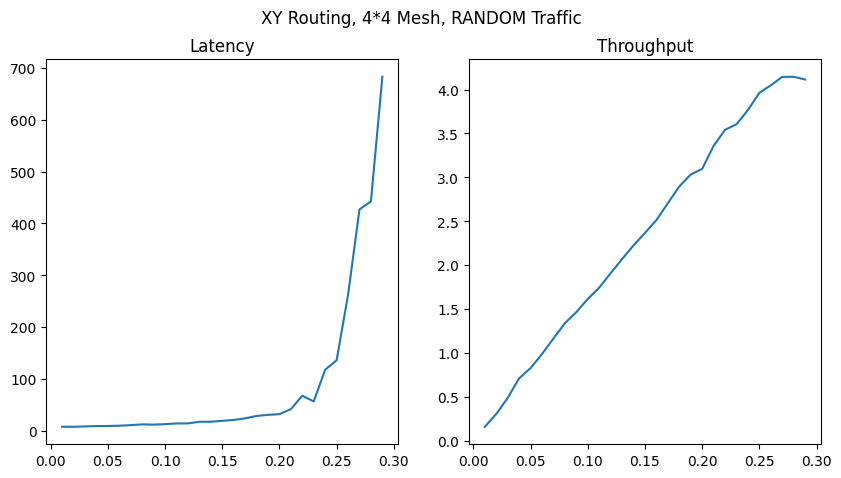

In [71]:

routing = Routing.XY
traffic = Traffic.RANDOM
rng = { "start": 0.01 , "end" : 0.3 , "step" : 0.01}
size = [4,4]

results = runOnRange(routing ,size ,traffic ,rng )
loads = [result[0] for result in results]
latency = [result[1]['average_delay'] for result in results]
throughput = [result[1]['network_throughput'] for result in results]

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle(f'{routing.name} Routing, {size[0]}*{size[1]} Mesh, {traffic.name} Traffic')

ax1.plot(loads, latency)
ax1.set_title('Latency')

ax2.plot(loads, throughput)
ax2.set_title('Throughput')

fig.set_figwidth(10)
fig.set_figheight(5)

plt.show()

In [ ]:

routing = Routing.XY
traffic = Traffic.RANDOM
rng = { "start": 0.01 , "end" : 0.3 , "step" : 0.01}
size = [4,4]

results = runOnRange(routing ,size ,traffic ,rng )
loads = [result[0] for result in results]
latency = [result[1]['average_delay'] for result in results]
throughput = [result[1]['network_throughput'] for result in results]

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle(f'{routing.name} Routing, {size[0]}*{size[1]} Mesh, {traffic.name} Traffic')

ax1.plot(loads, latency)
ax1.set_title('Latency')

ax2.plot(loads, throughput)
ax2.set_title('Throughput')

plt.show()

In [52]:
cmd = make_cmd(load=0.1, routing=Routing.XY , size=[4,4], traffic=Traffic.RANDOM)
print(f"{bin_path} {cmd}")
run_nox(cmd)

/opt/noxim/bin/noxim -power /opt/noxim/bin/power.yaml -config /opt/noxim/config_examples/default_config.yaml -pir 0.0125 poisson -dimx 4 -dimy 4 -routing XY -traffic random


{'total_received_packets': 1811,
 'average_delay': 13.3506,
 'network_throughput': 1.60944,
 'total_energy': 2.15717e-06}

In [ ]:
def main():
    parser = argparse.ArgumentParser(description="Run Noxim simulations and plot results")
    parser.add_argument("routing", help="The routing algorithm to use")
    parser.add_argument("network", help="The network configuration")
    parser.add_argument("traffic", help="The traffic distribution")
    parser.add_argument("start_load", type=float, help="Starting network load")
    parser.add_argument("end_load", type=float, help="Ending network load")
    parser.add_argument("step", type=float, help="Step for load increment")
    
    args = parser.parse_args()

    results = []

    # Run Noxim with different loads and collect data
    # for load in range(args.start_load, args.end_load + 1, args.step):
    loads = list(frange(args.start_load, args.end_load + 0.0001,args.step))
    cnt = 0 
    sz = len(loads)
    for load in loads:
        cnt += 1
        print(f"Running simulation {cnt} of {sz}: load = {load}")
        output = run_noxim(load, args.routing, args.network, args.traffic)
        data = parse_noxim_output(output)
        results.append(data)

    print("Done running simulations")
    print("Results:")
    print(results)

    # print(results)

    # Plotting results
    
    latency = [result['average_delay'] for result in results]
    throughput = [result['network_throughput'] for result in results]


    fig, (ax1, ax2) = plt.subplots(1, 2)

    fig.suptitle(f'{args.routing} Routing, {args.network}*{args.network} Mesh, {args.traffic} Traffic')

    ax1.plot(loads, latency)
    # ax1.xlabel('Network Load')
    # ax1.ylabel('Latency')
    ax1.set_title('Latency')
    
    ax2.plot(loads, throughput)
    # ax2.xlabel('Network Throughput')
    # ax2.ylabel('Throughput')
    ax2.set_title('Throughput')

    fig.set_figwidth(10)
    fig.set_figheight(5)
    plt.savefig(f'{args.routing}_{args.network}_{args.traffic}.png')

if __name__ == "__main__":
    main()
    # print(parse_noxim_output(run_noxim(0.01, "XY", 5, "random")))
